active_trail_nodes(variables, observed=None, include_latents=False)
名称：激活线索节点
作用：返回给定节点 “variables” 为 KEY ，可达到的节点为 value
参数：observed = None，如果改定值，那么假设这些节点是被观察到的。那么将计算该轨迹
参数：include_latents = False 是否在返回的活动跟踪节点中包含潜在变量。

In [1]:
import daft
from pgmpy.base import DAG
from pgmpy.factors.discrete import TabularCPD
student = DAG()
student.add_nodes_from(['diff', 'intel', 'grades'])
student.add_edges_from([('diff', 'grades'), ('intel', 'grades')])
print(student.active_trail_nodes('diff'))  # {'diff': {'diff', 'grades'}}
print(student.active_trail_nodes(['diff', 'intel'], observed='grades'))
# {'diff': {'diff', 'intel'}, 'intel': {'diff', 'intel'}}

print(student.active_trail_nodes(['diff', 'intel']))
# 当 B 观测时，A和C可以进行连通。{'diff': {'diff', 'grades'}, 'intel': {'grades', 'intel'}}

{'diff': {'grades', 'diff'}}
{'diff': {'intel', 'diff'}, 'intel': {'intel', 'diff'}}
{'diff': {'grades', 'diff'}, 'intel': {'grades', 'intel'}}


<Axes:>

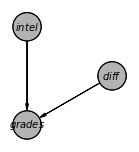

In [2]:
student.to_daft().render()

In [3]:
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.factors.discrete import TabularCPD
import daft

Axes(0,0;1x1)


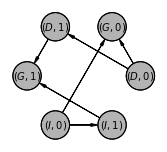

In [4]:
'''
add_cpds(*cpds)
名称：加入cpds (list, set, tuple (array-like)) 列表。每个 CPD 都应该是表格 CPD 的一个实例。
作用：将cpds加入到动态贝叶斯网络中。
注意：在cpd中添加变量和证据时，必须以下形式(node_name, time_slice)。这里，node_name是插入的节点，而time_slice是一个整数值，它表示节点所属的time_slice的索引。
'''
dbn = DBN()  # 实例化动态贝叶斯
# 添加网络有向边 (('D', 0),('G', 0)) 表示：时刻0的节点D 指向 时刻0的节点G
dbn.add_edges_from([(('D', 0),('G', 0)),(('I', 0),('G', 0)),(('D', 0),('D', 1)),(('I', 0),('I', 1))])
print(dbn.to_daft().render())  # 绘制此时构建的动态贝叶斯网络

In [5]:
grade_cpd = TabularCPD(('G', 0), 3, [[0.3, 0.05, 0.9, 0.5],
                                     [0.4, 0.25, 0.8, 0.03],
                                     [0.3, 0.7, 0.02, 0.2]],
                       evidence=[('I', 0),('D', 0)],
                       evidence_card=[2, 2])
d_i_cpd = TabularCPD(('D',1), 2, [[0.6, 0.3],
                                  [0.4, 0.7]],
                     evidence=[('D',0)],
                     evidence_card=[2])

diff_cpd = TabularCPD(('D', 0), 2, [[0.6], [0.4]])  # D_0 的 cpd
intel_cpd = TabularCPD(('I', 0), 2, [[0.7], [0.3]])  # I_0 的 cpd

i_i_cpd = TabularCPD(('I', 1), 2, [[0.5, 0.4],
                                   [0.5, 0.6]],
                     evidence=[('I', 0)],
                     evidence_card=[2])

dbn.add_cpds(grade_cpd, d_i_cpd, diff_cpd, intel_cpd, i_i_cpd)
print(type(dbn))

<class 'pgmpy.models.DynamicBayesianNetwork.DynamicBayesianNetwork'>


<class 'daft.PGM'>


<Axes:>

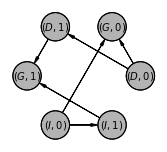

In [6]:
# 对 DBN 转为可展示的 daft.PGM 对象: 用于绘制 DAG 的对象。
print(type(dbn.to_daft()))
dbn.to_daft().render()

In [7]:
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.factors.discrete import TabularCPD
dbn = DBN()
dbn.add_edges_from([(('D',0),('G',0)),(('I',0),('G',0)),(('D',0),('D',1)),(('I',0),('I',1))])
grade_cpd =  TabularCPD(('G',0), 3, [[0.3,0.05,0.9,0.5],
                                     [0.4,0.25,0.8,0.03],
                                     [0.3,0.7,0.02,0.2]], [('I', 0),('D', 0)],[2,2])
dbn.add_cpds(grade_cpd)
print(dbn.get_cpds())


[<TabularCPD representing P(('G', 0):3 | ('I', 0):2, ('D', 0):2) at 0x1b2fff83ca0>]


# 动态贝叶斯网络的推理

In [8]:
'''
动态贝叶斯网络推理
'''
from pgmpy.factors.discrete import TabularCPD
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.inference import DBNInference
dbnet = DBN()
dbnet.add_edges_from([(('Z', 0), ('X', 0)), (('X', 0), ('Y', 0)),
                      (('Z', 0), ('Z', 1))])
z_start_cpd = TabularCPD(('Z', 0), 2, [[0.5], [0.5]])
x_i_cpd = TabularCPD(('X', 0), 2, [[0.6, 0.9],
                                   [0.4, 0.1]],
                     evidence=[('Z', 0)],
                     evidence_card=[2])
y_i_cpd = TabularCPD(('Y', 0), 2, [[0.2, 0.3],
                                   [0.8, 0.7]],
                     evidence=[('X', 0)],
                     evidence_card=[2])
z_trans_cpd = TabularCPD(('Z', 1), 2, [[0.4, 0.7],
                                       [0.6, 0.3]],
                         evidence=[('Z', 0)],
                         evidence_card=[2])
dbnet.add_cpds(z_start_cpd, z_trans_cpd, x_i_cpd, y_i_cpd)
dbnet.initialize_initial_state()
dbn_inf = DBNInference(dbnet)

# 使用信念传播的反向推理方法。
print(dbn_inf.backward_inference([('X', 0)], {('Y', 0): 0, ('Y', 1): 1, ('Y', 2): 1})[('X', 0)].values)
# 使用信念传播的前向推理方法。
print(dbn_inf.forward_inference([('X', 0)], {('Y', 0): 1, ('Y', 1): 0, ('Y', 2): 1})[('X', 0)].values)

# 默认为反向推理。
print(print(dbn_inf.query([('X', 0)], {('Y', 0): 0, ('Y', 1): 1, ('Y', 2): 1})[('X', 0)].values))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[0.66594382 0.33405618]


  0%|          | 0/1 [00:00<?, ?it/s]

[0.77419355 0.22580645]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[0.66594382 0.33405618]
None


# DBN 的的参数推理，即 CPD 学习

[('A', 0), ('B', 0), ('C', 0), ('D', 0), ('A', 1), ('B', 1), ('C', 1), ('D', 1)]
   (A, 0)  (B, 0)  (C, 0)  (D, 0)  (A, 1)  (B, 1)  (C, 1)  (D, 1)
0       2       0       1       0       1       1       0       2
1       2       1       1       2       0       0       1       0
2       0       0       1       0       1       2       0       0
3       0       2       1       1       0       2       0       1
4       2       1       0       2       1       0       1       2
5       0       0       1       0       2       0       1       0
6       0       1       0       1       1       1       0       0
7       1       0       0       2       2       1       0       1
8       1       0       0       2       2       1       0       0
9       1       2       1       0       1       1       0       0
BayesianNetwork with 8 nodes and 12 edges
+-----------+-----+
| (A, 0)(0) | 0.4 |
+-----------+-----+
| (A, 0)(1) | 0.3 |
+-----------+-----+
| (A, 0)(2) | 0.3 |
+-----------+-----+
+----------

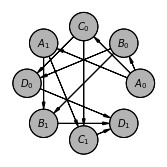

In [9]:
'''
由于假设 2-TBN 在整个模型中保持不变，因此该算法在数据中每 2 个连续的时间片上进行迭代，并根据它更新 CPD。

fit()
    data：pandas.DataFrame 实例 列名必须采用（变量、time_slice）形式，时间片必须从 0 开始
    estimator：str 目前仅支持最大似然估计器

    返回类型：没有返回值，仅仅将 CPD 添加到模型实例中。
'''
import numpy as np
import pandas as pd
from pgmpy.models import DynamicBayesianNetwork as DBN
model = DBN(
    [
        (("A", 0), ("B", 0)),
        (("A", 0), ("C", 0)),
        (("B", 0), ("D", 0)),
        (("C", 0), ("D", 0)),
        (("A", 0), ("A", 1)),
        (("B", 0), ("B", 1)),
        (("C", 0), ("C", 1)),
        (("D", 0), ("D", 1)),
    ]
)
data = np.random.randint(low=0, high=3, size=(10, 8))
colnames = []
# extend() :列表末尾一次性追加另一个序列中的多个值
for t in range(2):
    colnames.extend([("A", t), ("B", t), ("C", t), ("D", t)])

print(colnames)
df = pd.DataFrame(data, columns=colnames)  # 训练数据的形式！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！1
# pd.set_option('display.max_columns', 50)
print(df)
model.fit(df)


'''
get_constant_bn ( t_slice = 0 )

返回一个正常的贝叶斯网络对象，它具有来自前两个时间片的节点、第一个时间片中的所有边以及从第一个时间片到第二个时间片的边。返回的贝叶斯网络基本上代表了 DBN 中保持不变的部分。  节点名称更改为{var}_{time}形式的字符串。
'''
print(model.get_constant_bn())
model.get_constant_bn().to_daft().render()
#查看某节点概率分布
print(model.get_cpds(('A',0)))
print(model.get_cpds(('B',0)))
print(model.get_cpds(('C',0)))
print(model.get_cpds(('D',0)))
print(model.get_cpds(('A',1)))
print(model.get_cpds(('B',1)))
print(model.get_cpds(('C',1)))
print(model.get_cpds(('D',1)))

In [17]:
df.columns[0]

('A', 0)

In [16]:
type(df.columns[0][1])

int

In [10]:
'''
get_cpds()
    DBN 网络获取node的CPD参数： ('node', time-slice)  ------   return 可打印的 CPD表
    DBN 网络CPD参数： None   -----   return [可打印的 CPD 表]
'''
# DBN_CPD=model.get_cpds(('D', 0))  # 返回已与网络关联的 CPD
DBN_CPD=model.get_cpds()
for i in DBN_CPD:
    print(i)

+-----------+-----------+-----------+-----+--------------------+-----------+
| (B, 0)    | (B, 0)(0) | (B, 0)(0) | ... | (B, 0)(2)          | (B, 0)(2) |
+-----------+-----------+-----------+-----+--------------------+-----------+
| (C, 0)    | (C, 0)(0) | (C, 0)(1) | ... | (C, 0)(0)          | (C, 0)(1) |
+-----------+-----------+-----------+-----+--------------------+-----------+
| (D, 0)(0) | 0.0       | 1.0       | ... | 0.3333333333333333 | 0.5       |
+-----------+-----------+-----------+-----+--------------------+-----------+
| (D, 0)(1) | 0.0       | 0.0       | ... | 0.3333333333333333 | 0.5       |
+-----------+-----------+-----------+-----+--------------------+-----------+
| (D, 0)(2) | 1.0       | 0.0       | ... | 0.3333333333333333 | 0.0       |
+-----------+-----------+-----------+-----+--------------------+-----------+
+-----------+-----------+--------------------+--------------------+
| (A, 0)    | (A, 0)(0) | (A, 0)(1)          | (A, 0)(2)          |
+-----------+----

# 目前没有很好的 DBN 的动态结构学习方法

#### 模拟来自指定模型的时间序列数据。

In [11]:
'''
参数：
n_samples ( int ) – 要从模型中模拟的数据样本数。
n_time_slices ( int ) – 模拟数据的时间片数。
do ( dict ) – 适用于模型的干预措施。dict 的形式应该是 {(variable_name, time_slice): state}
证据( dict ) - 应用于模型的观察证据。dict 的形式应该是 {(variable_name, time_slice): state}
virtual_evidence ( list ) -- 概率性地将证据应用于模型。virtual_evidence应该是指定虚拟概率的pgmpy.factors.discret.TabularCPD对象的列表。

virtual_intervention ( list ) – 也称为软干预。virtual_intervention应该是指定虚拟/软干预概率的pgmpy.factors.discrete.TabularCPD对象列表。

include_latents ( boolean ( default: False ) ) -- 是否在生成的样本中包含潜在变量值。

seed ( int ( default: None ) ) -- 如果提供了一个值，则为 numpy.random 设置种子。
show_progress ( bool ) -- 如果为 True，则在生成样本时显示进度条。
返回：
pandas.DataFrame 带有模拟数据的数据框。
'''
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.factors.discrete import TabularCPD
dbn = DBN([(("D", 0), ("G", 0)), (("I", 0), ("G", 0)),
           (("D", 0), ("D", 1)), (("I", 0), ("I", 1)),])
diff_cpd = TabularCPD(("D", 0), 2, [[0.6], [0.4]])
grade_cpd = TabularCPD(variable=("G", 0), variable_card=3,
                       values=[[0.3, 0.05, 0.9, 0.5],
                               [0.4, 0.25, 0.08, 0.3],
                               [0.3, 0.7, 0.02, 0.2]],
                       evidence=[("I", 0), ("D", 0)],
                       evidence_card=[2, 2])
d_i_cpd = TabularCPD(variable=("D", 1), variable_card=2,
                     values=[[0.6, 0.3], [0.4, 0.7]],
                     evidence=[("D", 0)],
                     evidence_card=[2])
intel_cpd = TabularCPD(("I", 0), 2, [[0.7], [0.3]])
i_i_cpd = TabularCPD(variable=("I", 1), variable_card=2,
                     values=[[0.5, 0.4], [0.5, 0.6]],
                     evidence=[("I", 0)],
                     evidence_card=[2])
g_i_cpd = TabularCPD(variable=("G", 1), variable_card=3,
                     values=[[0.3, 0.05, 0.9, 0.5],
                             [0.4, 0.25, 0.08, 0.3],
                             [0.3, 0.7, 0.02, 0.2]],
                     evidence=[("I", 1), ("D", 1)],
                     evidence_card=[2, 2])
dbn.add_cpds(diff_cpd, grade_cpd, d_i_cpd, intel_cpd, i_i_cpd, g_i_cpd)

In [12]:
# 来自模型的正常模拟。
dbn.simulate(n_time_slices=4, n_samples=2)

  0%|          | 0/12 [00:00<?, ?it/s]

,"(D, 0)","(G, 0)","(I, 0)","(D, 1)","(G, 1)","(I, 1)","(D, 2)","(G, 2)","(D, 3)","(G, 3)","(I, 2)","(I, 3)"
0,0,0,0,0,0,1,1,0,0,1,1,0
1,1,1,0,1,2,0,1,1,1,0,0,1


In [13]:
# 有证据的模拟
dbn.simulate(n_time_slices=4, n_samples=2, evidence={('D', 0): 1, ('D', 2): 0})

  0%|          | 0/12 [00:00<?, ?it/s]

D:\Anaconda\envs\pytorch-cpu\lib\site-packages\pgmpy\sampling\Sampling.py:227: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sampled = sampled.append(_sampled).iloc[:size, :]
D:\Anaconda\envs\pytorch-cpu\lib\site-packages\pgmpy\sampling\Sampling.py:227: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sampled = sampled.append(_sampled).iloc[:size, :]
D:\Anaconda\envs\pytorch-cpu\lib\site-packages\pgmpy\sampling\Sampling.py:227: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sampled = sampled.append(_sampled).iloc[:size, :]
D:\Anaconda\envs\pytorch-cpu\lib\site-packages\pgmpy\sampling\Sampling.py:227: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

,"(D, 0)","(G, 0)","(I, 0)","(D, 1)","(G, 1)","(I, 1)","(D, 2)","(G, 2)","(D, 3)","(G, 3)","(I, 2)","(I, 3)"
0,1,2,0,0,0,1,0,0,0,0,1,1
1,1,2,0,0,1,0,0,1,0,0,0,0
